#A Few Resources to Help You Out

NMR - https://youtu.be/fG-ZexdlziU?si=Z5q9PBdnK6m4n_us (honestly this should suffice)

torch docs - https://docs.pytorch.org/docs/stable/torch.html



#Downloading and Loading The Dataset

We will be using gdown to download this dataset, gdown is an utility for downloading files on google drive which are publicly accessible. So first we do pip download to ensure these libraries aren't missing.(Note that outside of ipynb files in your terminal you will be using pip install "package name" without any exclaimation mark)

In [ ]:
!pip install gdown
!pip install rdkit

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1jIia0kHCUD7fr3VI6UFkRViSGBpGYmVg/view?usp=drive_link" -O dataset.pkl

Downloading...
From: https://drive.google.com/uc?id=1jIia0kHCUD7fr3VI6UFkRViSGBpGYmVg
To: /content/dataset.pkl
100% 85.3M/85.3M [00:01<00:00, 46.7MB/s]


In [ ]:
import pandas
import pickle
import rdkit.Chem as Chem
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
file_path = "dataset.pkl"
with open(file_path, 'rb') as file:
    data = pickle.load(file)

Now to examine the data before preprocessing steps.

In [ ]:
display(data.head())
display(data.info())

,NMREDATA_SOLVENT,NMREDATA_TEMPERATURE,NMREDATA_SMILES,NMREDATA_INCHI,NMREDATA_1D_13C,mol,NMREDATA_1D_1H
0,CDCl3\,298.0 K\,C1(C(C(C2(C(C1([H])[H])(C(C(=C(C2([H])[H])[H])...,InChI=1S/C15H22O3/c1-13(2)7-4-8-14(3)12(13)6-5...,Spectrum_Location=molecule/234\\nLarmor=50.0\\...,<rdkit.Chem.rdchem.Mol object at 0x7c45b6f11580>,NaN
1,CDCl3\,298.0 K\,C1(C(C2(C3(C1(C(=C(C3(C([H])([H])[H])[H])C(O[H...,InChI=1S/C15H24O/c1-10-4-7-15-11(2)12(9-16)8-1...,Spectrum_Location=molecule/2151\\nLarmor=125.0...,<rdkit.Chem.rdchem.Mol object at 0x7c45b6f115d0>,NaN
2,\,NaN,C1(C(C2(C3(C1(C(=C(C3(C([H])([H])[H])[H])C(O[H...,InChI=1S/C15H24O/c1-10-4-7-15-11(2)12(9-16)8-1...,Spectrum_Location=molecule/2151\\nLarmor=0.0\\...,<rdkit.Chem.rdchem.Mol object at 0x7c45b6f11620>,Spectrum_Location=molecule/2151\\nLarmor=0.0\\...
3,(CD3)2CO\,298.0 K\,[N+]1(=C(C(N(C1(C([H])([H])[H])C([H])([H])[H])...,"InChI=1S/C8H16N2O/c1-7(2)6-10(11)8(3,4)9(7)5/h...",Spectrum_Location=molecule/2189\\nLarmor=50.32...,<rdkit.Chem.rdchem.Mol object at 0x7c45b6f11670>,NaN
4,C6D6\,298.0 K\,C(=C(C1(C([H])([H])[H])C(C(=C([H])[H])C([H])([...,InChI=1S/C17H28O3/c1-8-16(7)10-15(19)17(12(4)5...,Spectrum_Location=molecule/2190\\nLarmor=125.7...,<rdkit.Chem.rdchem.Mol object at 0x7c45b6f116c0>,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63943 entries, 0 to 63942
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   NMREDATA_SOLVENT      63943 non-null  object
 1   NMREDATA_TEMPERATURE  5008 non-null   object
 2   NMREDATA_SMILES       63943 non-null  object
 3   NMREDATA_INCHI        63943 non-null  object
 4   NMREDATA_1D_13C       38591 non-null  object
 5   mol                   63943 non-null  object
 6   NMREDATA_1D_1H        18075 non-null  object
dtypes: object(7)
memory usage: 3.4+ MB


None

#Data Preprocessing

There are many null-values(missing) as can be seen from data.info() especially for the temperature and the 1H NMR peak locations.
Let's get started.

1)Drop the 1H spectrum and INCHI columns and also the rows where 13C or Temperature is unkown.(We will be using 13C for our predictions)

2)Remove the backslashes in Solvent and Temperature columns

3)Write a python function which takes the entries of the 13C spectrum column and turns it into an array(pytorch tensors) of peak locations. All tensors should be of the same size, size = max no of peak locations or you could use max no of carbons among all the mols of the dataset, pad the tensors with 0's if smaller.

4)Normalize temperature by dividing by the maximum value of the column, convert to tensors.

5)One-hot encode the solvents and save as pytorch tensors. Find out what unique solvents are there in the dataframe, maybe a pandas function could help.

6)Concat the spectrum, temperature and solvent tensors for each row. These will be the inputs to your neural network.

Preferably, write a python function which takes these values(temperature, peak locations, solvent) as input and gives out the tensor as output.

In [ ]:
#1
data.drop(columns=["NMREDATA_1D_1H", "NMREDATA_INCHI"], inplace=True)

In [ ]:
print(len(data['NMREDATA_TEMPERATURE']))
index1=data.loc[data["NMREDATA_TEMPERATURE"].isna()]
indices=index1.index
data.drop(index=indices, inplace=True)
index2= data.loc[data["NMREDATA_1D_13C"].isna()]
indices2= index2.index
data.drop(index=indices2, inplace=True)
print(len(data['NMREDATA_TEMPERATURE']))

63943
3479


In [ ]:
#2
data["NMREDATA_SOLVENT"] = (
    data["NMREDATA_SOLVENT"].str.replace("\\", "")
)

data["NMREDATA_TEMPERATURE"] = (
    data["NMREDATA_TEMPERATURE"].str.replace("\\", "")
)
print(data['NMREDATA_TEMPERATURE'])

0        298.0 K
1        298.0 K
3        298.0 K
4        298.0 K
6        298.0 K
          ...   
63938    298.0 K
63939    298.0 K
63940    298.0 K
63941    298.0 K
63942    298.0 K
Name: NMREDATA_TEMPERATURE, Length: 3479, dtype: object


In [ ]:
print(data['NMREDATA_SOLVENT'])

0           CDCl3
1           CDCl3
3        (CD3)2CO
4            C6D6
6           CDCl3
           ...   
63938        DMSO
63939        DMSO
63940       CDCl3
63941       CDCl3
63942        DMSO
Name: NMREDATA_SOLVENT, Length: 3479, dtype: object


In [ ]:
#3
arr =[]
def peak_tensor( column):
  length= []
  for element in column:
    temp_arr=[]
    string_elem = element.split('\n')
    for i in range(2,len(string_elem)):
       split=string_elem[i].split(',')
       temp_append=float(split[0])
       temp_arr.append(temp_append)
    arr.append(temp_arr)
  return arr



In [ ]:
print(data['NMREDATA_1D_13C'])
modified_13C=peak_tensor(data['NMREDATA_1D_13C'])
max_length=0


0        Spectrum_Location=molecule/234\\nLarmor=50.0\\...
1        Spectrum_Location=molecule/2151\\nLarmor=125.0...
3        Spectrum_Location=molecule/2189\\nLarmor=50.32...
4        Spectrum_Location=molecule/2190\\nLarmor=125.7...
6        Spectrum_Location=molecule/2191\\nLarmor=100.0...
                               ...                        
63938    Spectrum_Location=molecule/80041972\\nLarmor=5...
63939    Spectrum_Location=molecule/80041973\\nLarmor=5...
63940    Spectrum_Location=molecule/80042049\\nLarmor=5...
63941    Spectrum_Location=molecule/80042050\\nLarmor=5...
63942    Spectrum_Location=molecule/80042051\\nLarmor=5...
Name: NMREDATA_1D_13C, Length: 3479, dtype: object


In [ ]:
print(len(modified_13C))

3479


In [ ]:
for each in modified_13C :
  if len(each)>max_length:
    max_length=len(each)
print(max_length)

76


In [ ]:
print(data['NMREDATA_1D_13C'].shape)

(3479,)


In [ ]:
for each in modified_13C:
  if len(each)<max_length:
    for i in range(max_length-len(each)):
      each.append(0)


In [ ]:
print(len(modified_13C))

3479


In [ ]:
data['NMREDATA_1D_13C_MODIFIED']=modified_13C

In [ ]:
#4
data['NMREDATA_TEMPERATURE']=(data['NMREDATA_TEMPERATURE'].str.replace('K','').astype(float))
data['NMREDATA_TEMPERATURE']=data['NMREDATA_TEMPERATURE']/data['NMREDATA_TEMPERATURE'].max()




In [ ]:
print(data['NMREDATA_TEMPERATURE'])

0        0.820937
1        0.820937
3        0.820937
4        0.820937
6        0.820937
           ...   
63938    0.820937
63939    0.820937
63940    0.820937
63941    0.820937
63942    0.820937
Name: NMREDATA_TEMPERATURE, Length: 3479, dtype: float64


In [ ]:
#5
unique_solvents = (
    data['NMREDATA_SOLVENT'].unique()
)
print(data['NMREDATA_SOLVENT'].shape)
print(len(unique_solvents))



(3479,)
46


In [ ]:
solvent_dict={}
for i in range(len(unique_solvents)):
  solvent_dict[unique_solvents[i]]=i
for solvent in data['NMREDATA_SOLVENT']:
  data['NMREDATA_SOLVENT']=data['NMREDATA_SOLVENT'].replace(solvent,solvent_dict[solvent])

/tmp/ipython-input-520451799.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['NMREDATA_SOLVENT']=data['NMREDATA_SOLVENT'].replace(solvent,solvent_dict[solvent])


In [ ]:
print(data['NMREDATA_1D_13C_MODIFIED'].shape)


(3479,)


In [ ]:
#6

def concat_to_tensor(solvent, temperature,spectrum):


    spectrum = torch.tensor(spectrum, dtype=torch.float32)
    temperature = torch.tensor([temperature], dtype=torch.float32)
    solvent = torch.tensor([solvent], dtype=torch.float32)

    return torch.cat([spectrum, temperature, solvent])



In [ ]:
#7
concat_list= []
for i in range(len(data['NMREDATA_1D_13C_MODIFIED'])):
  concat_list.append(concat_to_tensor(data['NMREDATA_SOLVENT'].iloc[i],data['NMREDATA_TEMPERATURE'].iloc[i],data['NMREDATA_1D_13C_MODIFIED'].iloc[0]))
data['CONCAT'] = concat_list


#Label Creation

Possible atoms -
1) Use the rdkit mol object from your dataframe and write a python function which takes the mol object as input and returns the substrcutures present in the format of a dict, with 1 indicating prescence and 0 indicating absence. The below dictionary contains the substructures to look for, rdkit functions MolFromSmarts and HasSubstructMatch would be useful.

2) Use your function to generate labels for all the mol objects of the dataframe ans store it in a new column "labels". Again, ensure they are pytorch tensors. Now you are ready to train your model.

In [ ]:
fg_smarts = {
"sulfoxide":          "[#6][#16X3]=[OX1]",
"carbamate":          "[NX3][CX3](=[OX1])[OX2]",
"sulfonamide":        "[#16X4]([NX3])(=[OX1])(=[OX1])[#6]",
"ring_C_C_bond":      "[#6;R][#6;R]",
"ring_C_C_aromatic":  "[#6;R]=,:[#6;R]",
"hydrazone":          "[NX3][NX2]=[#6]",
"ether":              "[OD2]([#6])[#6]",
"amide":              "[NX3][CX3](=[OX1])[#6]",
"thiol_sulfide":      "[#6][#16X2]",
"methylene":          "[CX4H2]",
"quaternary_carbon":  "[CX4H0]",
"benzyl":             "[CX4][cX3]1[cX3][cX3][cX3][cX3][cX3]1",
"ring_C_N":           "[#6;R][#7;R]",
"alkene":             "[CX3]=[CX3]",
"sulfonate":          "[#16X4](=[OX1])(=[OX1])([#6])[OX2]",
"haloalkane":         "[#6][F,Cl,Br,I]",
"methyl":             "[CX4H3]",
"imine":              "[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]",
"aminal_like":        "[N][C][N]",
"phosphine":          "[#6][PX3]",
"allene":             "[C](=C)(=C)",
"nitrile":            "[NX1]#[CX2]",
"carboxylic_acid":    "[CX3](=O)[OX2H1]",
"aldehyde":           "[CX3H1](=O)[#6]",
"alkyne":             "[CX2]#[CX2]",
"thioamide":          "[NX3][CX3]=[SX1]",
"ester":              "[#6][CX3](=O)[OX2H0][#6]",
"methine":            "[CX4H1]",
"generic_imine":      "[C](=N)",
"carbonyl":           "[CX3]=[OX1]"
}

In [ ]:
print(len(fg_smarts))

30


In [ ]:
#1 Replace the function definition with your function
def get_substructure_dict(mol, fg_smarts):
    substructure_presence = {}

    for name, smarts in fg_smarts.items():
        patt = Chem.MolFromSmarts(smarts)
        substructure_presence[name] = int(mol.HasSubstructMatch(patt))

    return substructure_presence

In [ ]:
label_set=[]
for mol in data['mol']:
  label_set.append(get_substructure_dict(mol, fg_smarts))


In [ ]:
data['LABELS']=label_set

In [ ]:
#2 Write your script for converting all your mols to labels

#Build a Neural Network
Ensure all your inputs, labels and model all are on the same device(cuda) to enable GPU training and also ensure you are connected to T4 GPU. To move your model(or any other tensor as well) to your preferred device(cuda) use model.to(device)(or the other tensor name). Use **BCELoss** since you are doing a classification task. And use **sigmoid** as activation function for last neuron. The other activation functions should be **ReLU**. Use a batch size of 64.

1)Make a simple neural network of 3 hidden layers each of 100 nodes, 1 input layer and 1 output layer. The input layer is of size of the input tensor you created. The output size is 30 a.k.a your label size.

2)Write a training script to train your model, print train accuracy and test accuracy after each epoch.

3)Save your model to a pickle file.(Download the pkl files a.k.a your model weights and attach it in the google form)

4)Load your model again.

In [ ]:
device = torch.device("cuda")
print(torch.cuda.is_available()) # You get false if on CPU so change your device if you do.

True


In [ ]:
print(type(data['CONCAT'][7]))

<class 'torch.Tensor'>


In [ ]:
print(data['CONCAT'].shape)

(3479,)


In [ ]:
training_data = data['CONCAT'].sample(frac=0.8, random_state=42)
testing_data = data['CONCAT'].drop(training_data.index)
train_labels = data['LABELS'].loc[training_data.index]
test_labels = data['LABELS'].loc[testing_data.index]
print(training_data.shape)
print(testing_data.shape)

(2783,)
(696,)


In [ ]:
final_labels_train=[]
final_labels_test=[]
for each in train_labels:
  final_labels_train.append(list(each.values()))
for each in test_labels:
  final_labels_test.append(list(each.values()))

In [ ]:
print(final_labels_train)

[[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(train_labels)

50996    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
5296     {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
460      {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
5059     {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
49590    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
                               ...                        
47372    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
49638    {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
7906     {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
200      {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
4692     {'sulfoxide': 0, 'carbamate': 0, 'sulfonamide'...
Name: LABELS, Length: 2783, dtype: object


In [ ]:
train_tensor_labels = torch.tensor(final_labels_train)
test_tensor_labels = torch.tensor(final_labels_test)

In [ ]:
X_train = torch.stack(training_data.tolist())
X_test  = torch.stack(testing_data.tolist())


In [ ]:
import pickle
import torch

dataset_pkl = {
    "train_labels": train_tensor_labels,
    "test_labels": test_tensor_labels,
    "train_data": X_train,
    "test_data": X_test

}
with open("dataset.pkl", "wb") as f:
    pickle.dump(dataset_pkl, f)

print("Saved data.pkl")

Saved data.pkl


In [ ]:
from torch.utils.data import Dataset, DataLoader


class NMRDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y


In [ ]:
train_dataset = DataLoader(NMRDataset(X_train, train_tensor_labels), batch_size=64, shuffle=False)
test_dataset = DataLoader(NMRDataset(X_test, test_tensor_labels), batch_size=64, shuffle=False)

In [ ]:
class NN(nn.Module):
  def __init__(self, input_size,output_size):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 100)
    self.fc4 = nn.Linear(100, output_size)
    self.bn1 = nn.BatchNorm1d(100)
    self.bn2 = nn.BatchNorm1d(100)
    self.bn3 = nn.BatchNorm1d(100)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(0)
  def forward(self, x):
    x = self.relu(self.bn1(self.fc1(x)))
    x= self.dropout(x)
    x = self.relu(self.bn2(self.fc2(x)))
    x= self.dropout(x)
    x = self.relu(self.bn3(self.fc3(x)))
    x= self.dropout(x)
    x = self.sigmoid(self.fc4(x))
    return x


In [ ]:
input_size=((data['CONCAT'][0].shape[0]))
output_size=30
model = NN(input_size,output_size)
criteria = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model.train()
for i in range(400):
  for inputs, labels in train_dataset:
    optimizer.zero_grad()
    labels= labels.float()
    outputs = model(inputs)
    loss = criteria(outputs, labels)
    loss.backward()
    optimizer.step()
  print(f"Epoch {i+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.34842240810394287
Epoch 2, Loss: 0.3010931611061096
Epoch 3, Loss: 0.29078418016433716
Epoch 4, Loss: 0.285730242729187
Epoch 5, Loss: 0.28542444109916687
Epoch 6, Loss: 0.28656482696533203
Epoch 7, Loss: 0.28519386053085327
Epoch 8, Loss: 0.28339534997940063
Epoch 9, Loss: 0.28419438004493713
Epoch 10, Loss: 0.27957257628440857
Epoch 11, Loss: 0.2803322970867157
Epoch 12, Loss: 0.2793578803539276
Epoch 13, Loss: 0.278158038854599
Epoch 14, Loss: 0.28045594692230225
Epoch 15, Loss: 0.2778281271457672
Epoch 16, Loss: 0.27761223912239075
Epoch 17, Loss: 0.2749655246734619
Epoch 18, Loss: 0.2738901674747467
Epoch 19, Loss: 0.27284982800483704
Epoch 20, Loss: 0.2733383774757385
Epoch 21, Loss: 0.27037161588668823
Epoch 22, Loss: 0.26993677020072937
Epoch 23, Loss: 0.26907986402511597
Epoch 24, Loss: 0.2675119936466217
Epoch 25, Loss: 0.26676517724990845
Epoch 26, Loss: 0.2660158574581146
Epoch 27, Loss: 0.2644079327583313
Epoch 28, Loss: 0.26539427042007446
Epoch 29, Loss:

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataset:
        labels = labels.float()
        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        correct += (preds == labels).sum().item()
        total += labels.numel()

print("Label-wise accuracy:", correct / total)


In [ ]:
import torch

# save only the weights
torch.save(model.state_dict(), "nmr_model_weights.pkl")

#Extras

For those done with CNN's/LSTM try implementing CNN or LSTM on this dataset. The paper has pretty descript images for both which are as follows.

https://sourceforge.net/projects/nmrshiftdb2/files/data/ - this link can be used to procure nmrshiftdb2 data without any editing done by me.

Though nmrshiftdb2.sd, nmrshiftdb2.xml and nmrshiftdb2.nmredata.sd I have tried out. Out of these, the dataset you used in this has been made from nmrshiftdb2.nmredata.sd which doesn't contain magnetic field values but has CTAB blocks which make getting mol objects easy. sd files have SDMolSupplier function of rdkit to make life easier, but the other sd's data is stored in the xml file with the same name. Which also contains the field data which we haven't used in this notebook.

Anyways, this is the actual dataset and model building begins except for those not done with CNN's or LSTM. Good Luck and ping me for any doubts.

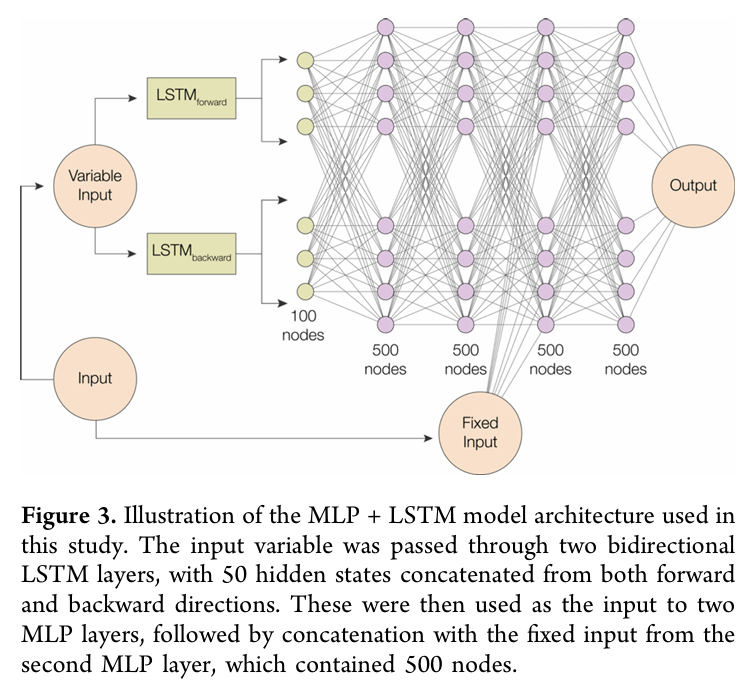


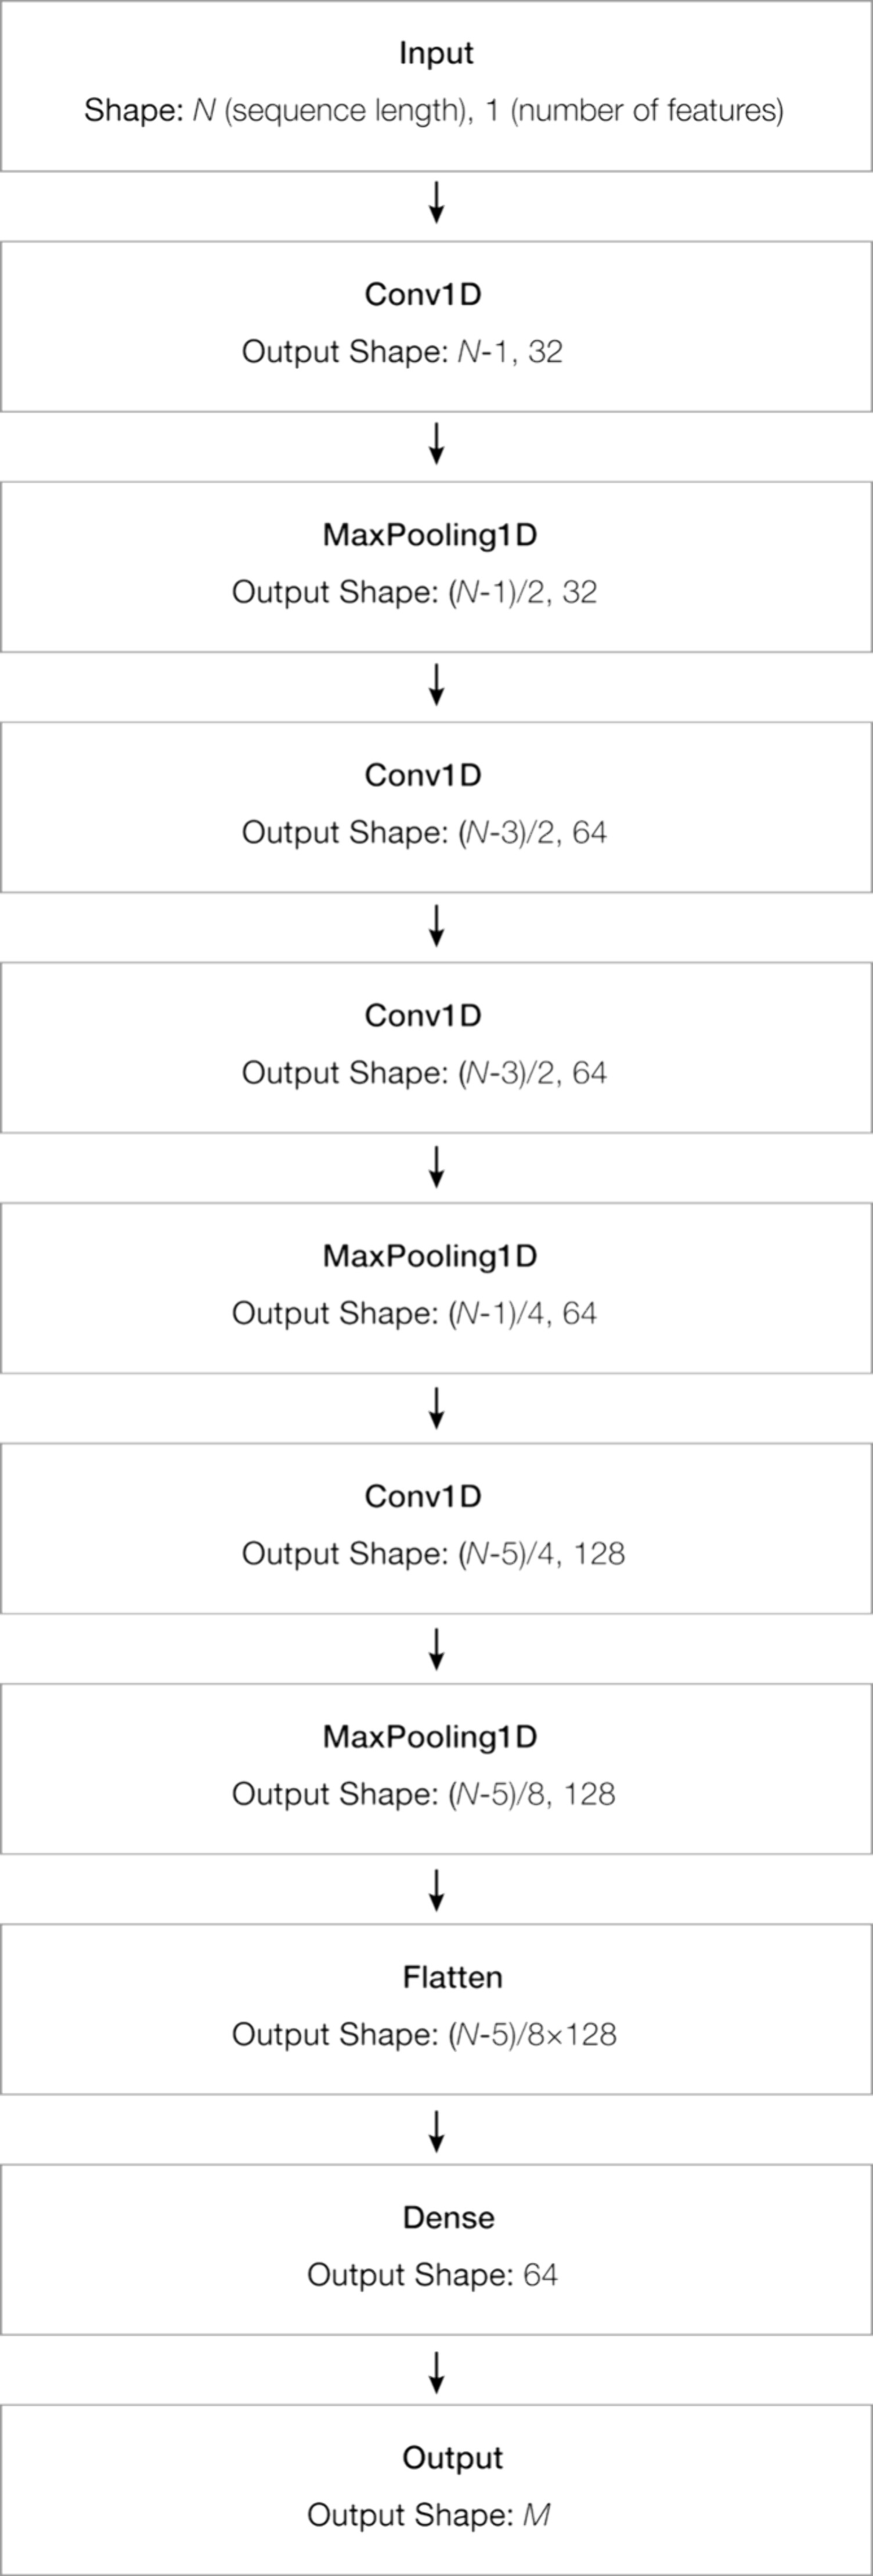